In [142]:
'''
TODO 
As guidelines:
- https://github.com/ocatak/lstm_malware_detection/blob/master/deep_learnin_lstm_malware_detection.ipynb
- https://www.kaggle.com/code/hamzamanssor/detection-malware-using-machine-learning-models/notebook
As theory:
- https://y.com.sb/watch?v=YRhxdVk_sIs
- https://y.com.sb/playlist?list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1
As practical: 
- https://y.com.sb/watch?v=cOos6wRMpAU

'''

'\nTODO \nAs guidelines:\n- https://github.com/ocatak/lstm_malware_detection/blob/master/deep_learnin_lstm_malware_detection.ipynb\n- https://www.kaggle.com/code/hamzamanssor/detection-malware-using-machine-learning-models/notebook\nAs theory:\n- https://y.com.sb/watch?v=YRhxdVk_sIs\n- https://y.com.sb/playlist?list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1\nAs practical: \n- https://y.com.sb/watch?v=cOos6wRMpAU\n\n'

# About the dataset

CYP-GUIDES (Cytochrome Psychotropic Genotyping Under Investigation for Decision Support) is a randomized controlled trial (RCT) comparing 2 outcomes in hospitalized patients with severe depressive disorders treated according to the patient's CYP2D6 genotype and functional status versus standard psychotropic therapy. The primary outcome was hospital Length of Stay (LOS) and the secondary outcome was the Re-Admission Rate (RAR) 30 days after discharge.

The trial setting was the Institute of Living at Hartford Hospital. CYP2D6 genotyping was implemented to characterize the functional status of the CYP2D6 enzyme with sub-normal, normal or supra-normal function. The electronic medical record (EMR) was utilized to transmit clinically actionable drug prescribing guidance based on the patient's CYP2D6 function to the physician.

The RCT recruited 1500 patients, genotyped CYP2D6 in 1459, and randomized 477 to standard therapy (Group S), for whom treatment-as-usual guidance was delivered without consideration of patient CYP2D6 genotype, and 982 to genetically-guided therapy (Group G) where CYP2D6-based treatment recommendations were provided via EMR to physicians. For inpatients in Group G whose CYP2D6 function was sub- or supra-normal, medications primarily metabolized by the CYP2D6 enzyme were proscribed.

The RCT developed a database of potential benefit to the field. The pharmacologic, clinical course and pharmacogenetic therapeutic guidance is being published in a related article. These data should enable various investigators to assess effects of clinical decision support on resource utilization and psychotropic therapy during psychiatric hospitalizations. 

### About CYP2D6
<p><a href='https://en.wikipedia.org/wiki/CYP2D6'>From Wikipedia, the free encyclopedia</a></p>
Cytochrome P450 2D6 (CYP2D6) is an enzyme that in humans is encoded by the CYP2D6 gene. CYP2D6 is primarily expressed in the liver. It is also highly expressed in areas of the central nervous system, including the substantia nigra.

CYP2D6, a member of the cytochrome P450 mixed-function oxidase system, is one of the most important enzymes involved in the metabolism of xenobiotics in the body. In particular, CYP2D6 is responsible for the metabolism and elimination of approximately 25% of clinically used drugs, via the addition or removal of certain functional groups – specifically, hydroxylation, demethylation, and dealkylation.[3] CYP2D6 also activates some prodrugs. This enzyme also metabolizes several endogenous substances, such as hydroxytryptamines, neurosteroids, and both m-tyramine and p-tyramine which CYP2D6 metabolizes into dopamine in the brain and liver.[3][4]

Considerable variation exists in the efficiency and amount of CYP2D6 enzyme produced between individuals. Hence, for drugs that are metabolized by CYP2D6 (that is, are CYP2D6 substrates), certain individuals will eliminate these drugs quickly (ultrarapid metabolizers) while others slowly (poor metabolizers). If a drug is metabolized too quickly, it may decrease the drug's efficacy while if the drug is metabolized too slowly, toxicity may result.[5] So, the dose of the drug may have to be adjusted to take into account of the speed at which it is metabolized by CYP2D6.[6]
<hr>

In [143]:
import shutil
from zipfile import ZipFile as zf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV
from sklearn.model_selection import train_test_split,cross_validate,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from xgboost import XGBRegressor
from keras.layers import Dense,Flatten,Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras_tuner import HyperParameters,RandomSearch
# What version of Python do you have?
import sys
from keras import __version__
import pandas as pd
import sklearn as sk
import tensorflow as tf
'''
The following two 'detect_outliers' functions have been taken from 'Finding an outlier in a dataset using Python' by Krish Naik. All credit goes to him.
https://www.youtube.com/embed/rzR_cKnkD18
'''
outliers = []

def detect_outliers_std(df):
    threshold=3 # Can change
    mean = np.mean(df)
    std = np.std(df)

    for point in df:
        z_score = (point-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(point)
        
    return outliers
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

def calculate_correlation(df, column1, column2):
    correlation = df[column1].corr(df[column2])
    return correlation
def convert_days(days):
    years, days = divmod(days, 365) 
    months, days = divmod(days, 30)  
    print(f'Most extreme patient spent {years} years, {months} months and {days} days in the clinic')
def clean_useless_cols(df, y_label):
    print('#########################')
    print(f'starting with {df.columns.size} cols')
    print('#########################')
    print(df.corr().nlargest(df.columns.size, y_label)
          [y_label].sort_values(ascending=True))
    irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()
    ir_cols_list = irrelevant_cols[irrelevant_cols[y_label]].index
    print('\n#########################')
    print('irrelevant cols found (constants):')
    print('#########################')
    print(df[ir_cols_list].nunique())
    df.drop(ir_cols_list, axis=1, inplace=True)
    print('\n#########################')
    print(f'voila! set cleared. {df.columns.size} cols left to work with')
    print('#########################')

'''
The following function 'detect_software_version_and_GPU' (below) is not mine, credit goes to: Professor Jeff Heaton
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/install/tensorflow-install-march-2023.ipynb
'''
def detect_software_version_and_GPU():
    print(f"Tensor Flow Version: {tf.__version__}")
    print(f"Keras Version: {__version__}")
    print()
    print(f"Python {sys.version}")
    print(f"Pandas {pd.__version__}")
    print(f"Scikit-Learn {sk.__version__}")
    gpu = len(tf.config.list_physical_devices('GPU'))>0
    print("GPU is", "available" if gpu else "NOT AVAILABLE")

detect_software_version_and_GPU()

Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
Pandas 2.0.1
Scikit-Learn 1.2.2
GPU is available


In [144]:
# unrar
SEED = 101

'''
Dataset taken from https://data.mendeley.com/datasets/25yjwbphn4/1

'''
with zf('Clinic.zip','r') as zin:
    zin.extractall()
    shutil.rmtree('25yjwbphn4-1')

In [145]:
# load data
df = pd.read_csv('Dataset.csv',encoding='utf-8')
medications = pd.read_csv('Medicationkey.csv')

df.rename(columns={'ID': 'Patient'}, inplace=True)
df.set_index('Patient',inplace=True)
medications.set_index('Medication', inplace=True)

# As-is, drug names have been shortened to alphabet letters, let's revert that
old_columns = medications.values.flatten()
new_columns = medications.index

for old, new in zip(old_columns, new_columns):
    df.rename(columns={old: new}, inplace=True)

In [146]:
# Get a sense of what features we are dealing with in this set
df.columns

Index(['GENDER', 'AGE', 'RACE/ETHNICITY', 'Diagnosis', 'MD', 'Assignment',
       'EMR', 'LOS', 'RAR', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE',
       'BUPROPION', 'CHLORPROMAZINE', 'CITALOPRAM', 'CLOMIPRAMINE',
       'CLONIDINE', 'DOXEPIN', 'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE',
       'FLUPHENAZINE', 'FLUVOXAMINE', 'GUANFACINE', 'HALOPERIDOL',
       'IMIPRAMINE', 'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'MIRTAZAPINE',
       'NORTRIPTYLINE', 'OLANZAPINE', 'PALIPERIDONE', 'PERPHENAZINE',
       'QUETIAPINE', 'RISPERIDONE', 'SERTRALINE', 'TRAZODONE', 'VENLAFAXINE',
       'ZIPRASIDONE', '# Psychotropic Medications', '# Administrations',
       'Therapeutic Guidances'],
      dtype='object')

#### Handy Terminology
<ul>
<li>MD: Medical Doctor (Psychiatrist)</li>
<li>EMR: Electronic Medical Record</li>
<li>LOS: Length of Stay</li>
<li>RAR: Re-Admission Rate</li>
</ul>

In [147]:
# Clean unconventional column names

# This is the equivalent of counting all drug columns suministered to the patient. We will later see how to use this
df.rename(columns={'# Administrations': 'Administrations'}, inplace=True)

df.rename(columns={'# Psychotropic Medications': 'Psychotropics'}, inplace=True)
df.rename(columns={'RACE/ETHNICITY': 'Ethnicity'}, inplace=True)

In [148]:
print('Checking for void values:')
df[df.columns[df.isnull().any()]].isnull().sum()

Checking for void values:


Assignment               41
Therapeutic Guidances    41
dtype: int64

In [149]:
print(f'Not all patients are followed according to their CYP2D6 genome performance: {df["Assignment"].unique()}')
df[['Assignment','LOS','RAR']].groupby(['Assignment']).describe().transpose()

Not all patients are followed according to their CYP2D6 genome performance: ['G' 'S' nan]


Assignment            G            S
LOS count    982.000000   477.000000
    mean     178.511202   172.607966
    std      186.889539   149.487751
    min       14.000000     6.000000
    25%       90.000000    89.000000
    50%      139.500000   134.000000
    75%      189.750000   197.000000
    max     2776.000000  1629.000000
RAR count    982.000000   477.000000
    mean       0.100815     0.090147
    std        0.301237     0.286693
    min        0.000000     0.000000
    25%        0.000000     0.000000
    50%        0.000000     0.000000
    75%        0.000000     0.000000
    max        1.000000     1.000000

In [150]:
# Checking whether patients who received no therapeutic guidance make a union join with those who don't share the genome in question
print(f"Patients who received no therapeutic guidance: {df[df['Therapeutic Guidances'].isnull()].index}")
print(f"Patients who are not related to the CYP2D6 genome: {df[df['Therapeutic Guidances'].isnull()].index}")
print(f"\ninner joining both groups: {df[(df['Assignment'].isnull())&(df['Therapeutic Guidances'].isnull())].shape[0]} patients")

Patients who received no therapeutic guidance: Index([   8,   10,   32,   37,   39,   40,   41,   42,   43,   52,  264,  271,
        282,  353,  360,  420,  462,  493,  562,  625,  635,  705,  817,  834,
        851,  896,  984, 1068, 1126, 1208, 1272, 1335, 1336, 1371, 1380, 1381,
       1382, 1383, 1386, 1406, 1448],
      dtype='int64', name='Patient')
Patients who are not related to the CYP2D6 genome: Index([   8,   10,   32,   37,   39,   40,   41,   42,   43,   52,  264,  271,
        282,  353,  360,  420,  462,  493,  562,  625,  635,  705,  817,  834,
        851,  896,  984, 1068, 1126, 1208, 1272, 1335, 1336, 1371, 1380, 1381,
       1382, 1383, 1386, 1406, 1448],
      dtype='int64', name='Patient')

inner joining both groups: 41 patients


In [151]:
'''
My strategy: 
Initially I opted for filling NaN with the most frequent value for each category, but this lead to a model that didn't perform as well as if you kept those groups 'as is'.
As a consequence of this, I have chosen to simply drop the patients who weren't followed as thoroughly as those with CYP2D6 tracking
'''
df.dropna(subset=['Assignment','Therapeutic Guidances'],inplace=True)
# We're back to 1459 patients, as the study suggests

In [152]:
# We have a problem here: Multiple values for one column
pd.DataFrame(df['Diagnosis'].unique())

,0
0,"MDD, Recurrent, Unspecified"
1,"MDD, Single Episode, Severe With Psychotic Fea..."
2,Depressive Disorder NOS
3,"MDD, Single Episode,Severe Without Psychotic F..."
4,"MDD, Single Episode, Unspecified"
5,"MDD, Recurrent, Severe With Psychotic Features"
6,"MDD, Recurrent, Severe Without Psychotic Features"
7,"MDD, Recurrent, Moderate"
8,Mood Disorder NOS
9,Schizoaffective Disorder


/home/maestro/mambaforge/envs/tf/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/home/maestro/mambaforge/envs/tf/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


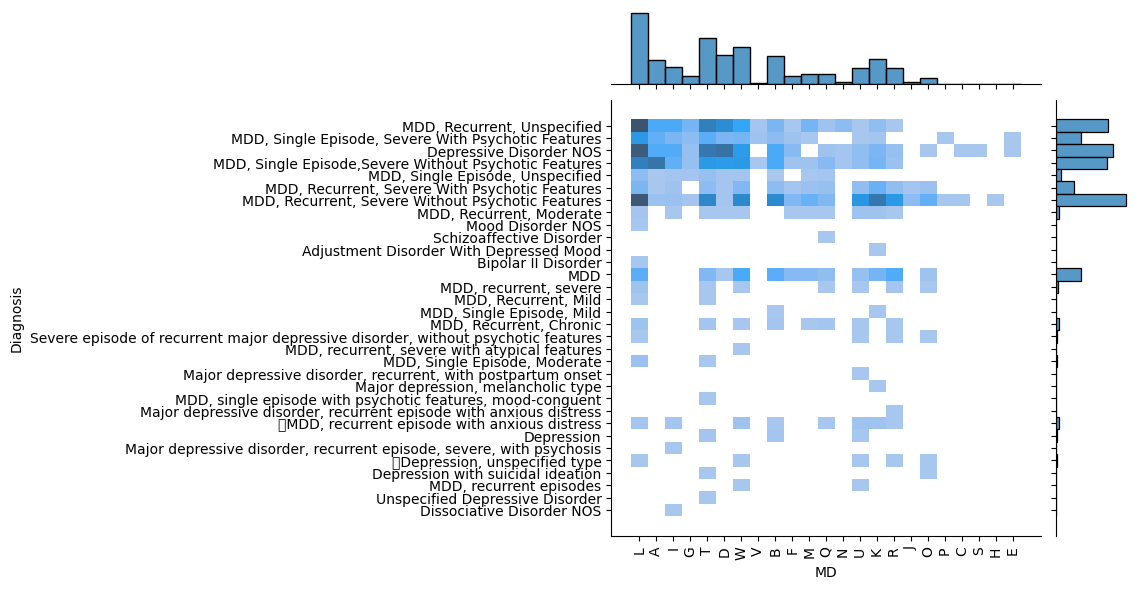

In [153]:
# Should we drop it?
sns.jointplot(data=df,x='MD',y='Diagnosis',kind='hist')
plt.xticks(rotation=90);

/home/maestro/mambaforge/envs/tf/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/home/maestro/mambaforge/envs/tf/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


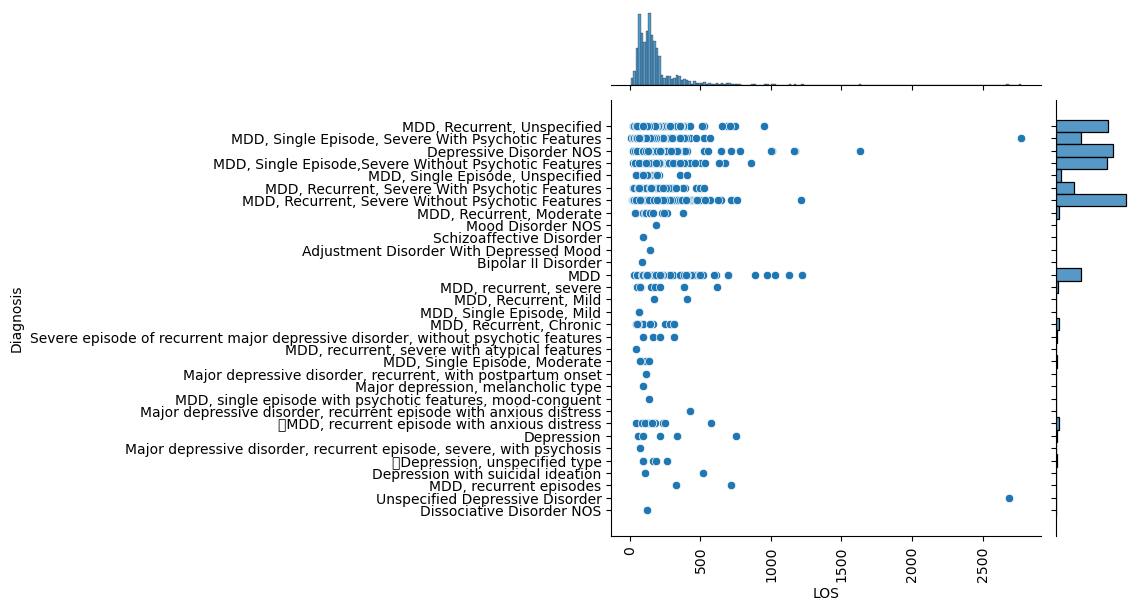

In [154]:
# Should we drop it?
sns.jointplot(data=df,x='LOS',y='Diagnosis')
plt.xticks(rotation=90);

In [155]:
df['Diagnosis'] = OrdinalEncoder().fit_transform(df['Diagnosis'].to_numpy().reshape(-1,1))
corr_rar = np.around(calculate_correlation(df,'RAR','Diagnosis'),4)
corr_los = np.around(calculate_correlation(df,'LOS','Diagnosis'),4)
print(f'RAR and Diagnosis are {corr_rar}% corr while LOS and Diagnosis are {corr_los}% correlated')

# Drop Diagnosis as it is not important to predict LOS
df.drop('Diagnosis',axis=1,inplace=True)

RAR and Diagnosis are 0.0209% corr while LOS and Diagnosis are -0.0039% correlated


In [107]:
df['MD'] = OrdinalEncoder().fit_transform(df['MD'].to_numpy().reshape(-1,1))
corr_rar = np.around(calculate_correlation(df,'RAR','MD'),4)
corr_los = np.around(calculate_correlation(df,'LOS','MD'),4)
print(f'RAR and MD are {corr_rar}% corr while LOS and MD are {corr_los}% correlated')

# Drop MD as it is not important to predict LOS
df.drop('MD',axis=1,inplace=True)

RAR and MD are -0.0358% corr while LOS and MD are 0.0906% correlated


,LOS,Ethnicity_B,Ethnicity_L,Ethnicity_O/U,Ethnicity_W
LOS,1.000000,-0.060918,-0.117303,-0.007750,0.147241
Ethnicity_B,-0.060918,1.000000,-0.219160,-0.083318,-0.434408
Ethnicity_L,-0.117303,-0.219160,1.000000,-0.130574,-0.680794
Ethnicity_O/U,-0.007750,-0.083318,-0.130574,1.000000,-0.258817
Ethnicity_W,0.147241,-0.434408,-0.680794,-0.258817,1.000000


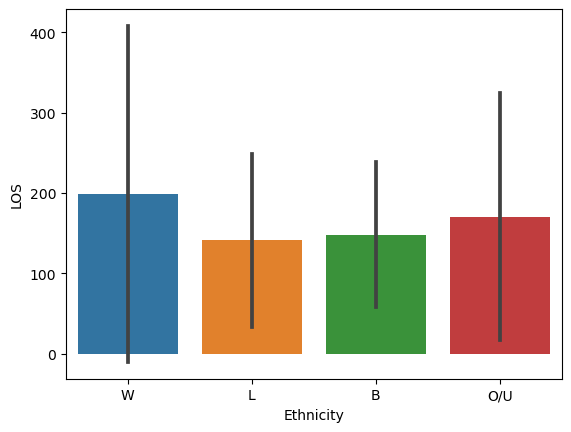

In [108]:
# Looking at more columns for influence...
# White patients tend to vary most and have on avg the majority of LOS
sns.barplot(data=df, x='Ethnicity', y='LOS', estimator=np.mean, errorbar='sd')
# However the Ethnicity coefficient is not that significant... 
# Nonetheless, 0.15 coefficient could potentially influence the outcome if the patient is of white ethnicity. 
race = df[['LOS','Ethnicity']]
pd.get_dummies(race).corr()

#########################
Discharged people : 1317 Recurrent people: 142 with a 9.27 times imbalance
#########################


RAR,0,1
GENDER,1317,142


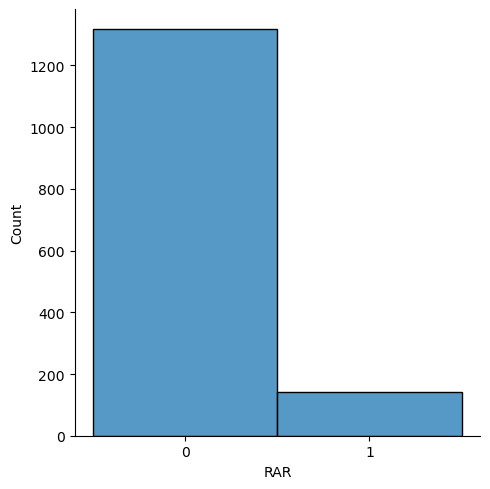

In [109]:
# Understanding what to predict: RAR or LOS ?

# Convert to string for plotting
df['RAR'] = df['RAR'].astype(str)
discharged_ppl,recurrent_ppl = df['RAR'].value_counts()
imbalance_ratio = np.around(discharged_ppl / recurrent_ppl,2)
print('#########################')
print(f'Discharged people : {discharged_ppl} Recurrent people: {recurrent_ppl} with a {imbalance_ratio} times imbalance')
print('#########################')
sns.displot(df['RAR'],bins=2)
df.groupby(['RAR']).count().transpose().head(1)

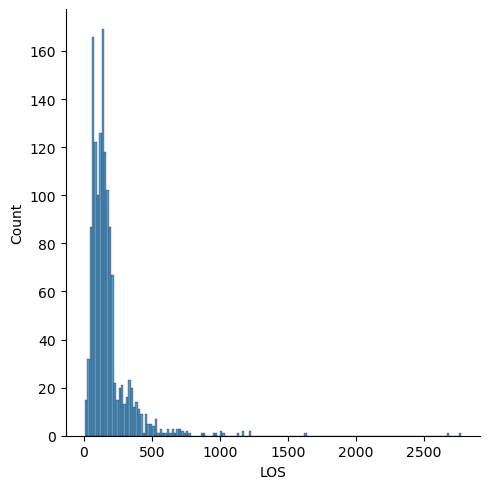

count    1459.000000
mean      176.581220
std       175.510693
min         6.000000
25%        90.000000
50%       138.000000
75%       191.000000
max      2776.000000
Name: LOS, dtype: float64


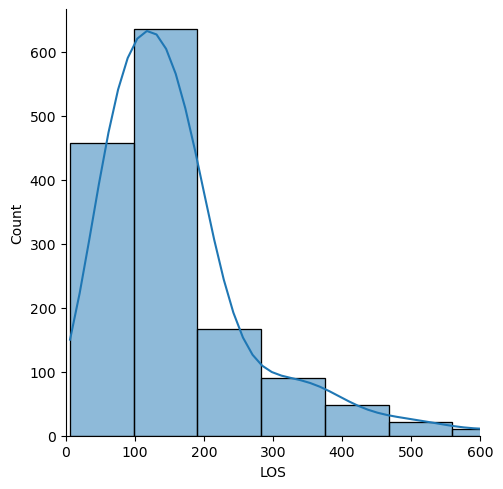

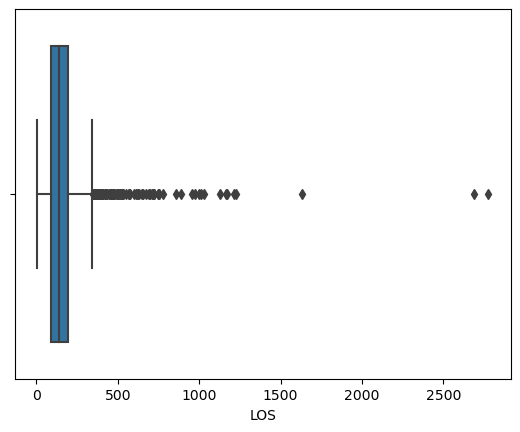

Most extreme patient spent 7 years, 7 months and 11 days in the clinic


In [67]:
# Since RAR is heavely imbalanced, let's try to focus on another outcome: The Length of Stay (LOS)

sns.displot(df['LOS'])
plt.show()
# Most patients don't stay more than 200 days
print(df['LOS'].describe())
sns.displot(data=df,x='LOS',bins=30,kde=1)
plt.xlim(0,600)
plt.show()
# Possibly detecting outliers
sns.boxplot(data=df,x='LOS')
plt.show()
# Making sense of outliers
convert_days(df['LOS'].max())

In [68]:
outliers_std = sorted(detect_outliers_std(df['LOS']))
std_df = pd.DataFrame(outliers_std, columns=['outlier'])
outliers_iqr = sorted(detect_outliers_iqr(df['LOS']))
iqr_df = pd.DataFrame(outliers_iqr, columns=['outlier'])

# TODO start from IQR, but when you reach the range where std says there should be outliers, swap those IQR says at that range (they are more) with those std says and test 
# scores again

# Combined outliers
pd.concat([iqr_df, std_df]).drop_duplicates()


,outlier
0,349
1,350
2,351
3,352
4,353
...,...
133,1215
134,1223
135,1629
136,2685


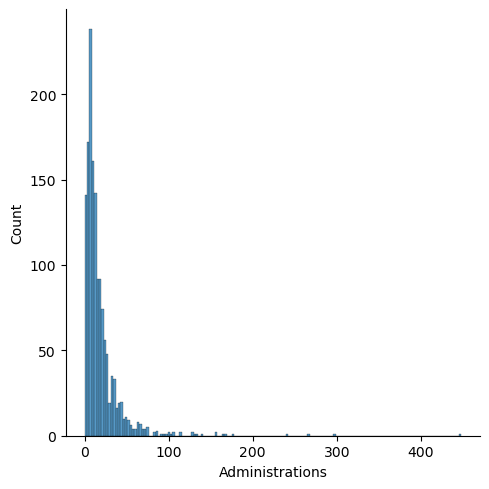

count    1459.000000
mean       18.220699
std        25.384977
min         0.000000
25%         6.000000
50%        12.000000
75%        22.000000
max       448.000000
Name: Administrations, dtype: float64


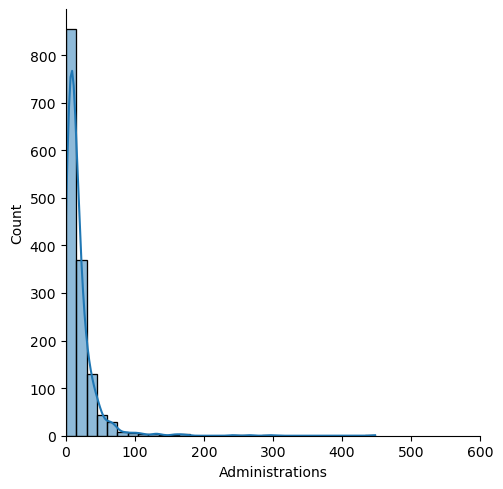

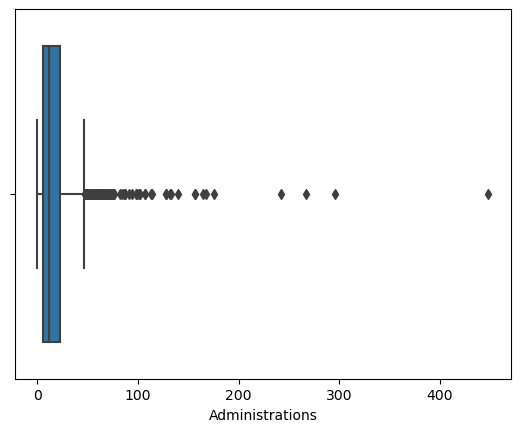

Most extreme patient had to take 448 medications


,GENDER,AGE,Ethnicity,Assignment,EMR,LOS,RAR,AMITRIPTYLINE,ARIPIPRAZOLE,ASENAPINE,...,PERPHENAZINE,QUETIAPINE,RISPERIDONE,SERTRALINE,TRAZODONE,VENLAFAXINE,ZIPRASIDONE,Psychotropics,Administrations,Therapeutic Guidances
Patient,,,,,,,,,,,,,,,,,,,,,
1060,F,66,W,G,E,2685,0,0,12,0,...,0,0,0,0,111,0,0,6,448,EG


In [69]:
# Now looking at amount of drugs taken in clinic
sns.displot(df['Administrations'])
plt.show()
# Most patients don't stay more than 200 days
print(df['Administrations'].describe())
sns.displot(data=df,x='Administrations',bins=30,kde=1)
plt.xlim(0,600)
plt.show()
# Possibly detecting outliers
sns.boxplot(data=df,x='Administrations')
plt.show()
extreme_n_drugs = df['Administrations'].max()
print(f'Most extreme patient had to take {extreme_n_drugs} medications')
df[df['Administrations']==df['Administrations'].max()]

In [70]:
# Problematic columns for ML
for col in df.select_dtypes(include='object').columns:
    print(f'Column {col} has the following values:')
    print(df[col].value_counts())
    print('#########################')

# Except for the MD column, I would encourage doing a OneHotEncoding on each
# TODO solve categorical columns

Column GENDER has the following values:
GENDER
F    744
M    715
Name: count, dtype: int64
#########################
Column Ethnicity has the following values:
Ethnicity
W      838
L      373
B      179
O/U     69
Name: count, dtype: int64
#########################
Column Assignment has the following values:
Assignment
G    982
S    477
Name: count, dtype: int64
#########################
Column EMR has the following values:
EMR
C    826
E    633
Name: count, dtype: int64
#########################
Column RAR has the following values:
RAR
0    1317
1     142
Name: count, dtype: int64
#########################
Column Therapeutic Guidances has the following values:
Therapeutic Guidances
EG    1000
CT     393
TL      66
Name: count, dtype: int64
#########################


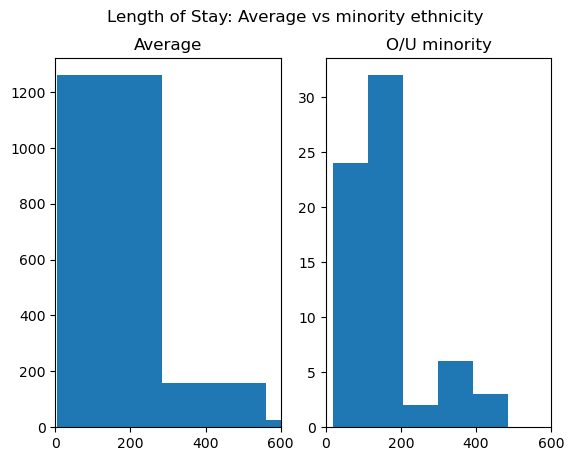

<Axes: xlabel='Ethnicity', ylabel='LOS'>

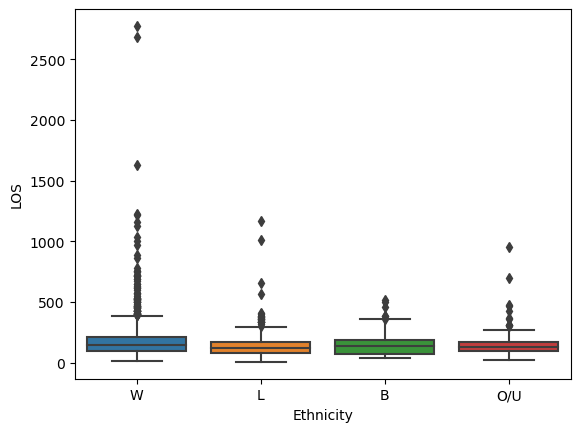

In [71]:
fig, ax = plt.subplots(ncols=2,nrows=1)
ax[0].hist(df['LOS'])
ax[0].set_xlim([0, 600])
ax[0].set_title('Average')
ax[1].hist(df[df['Ethnicity']=='O/U']['LOS'])
ax[1].set_title('O/U minority')
ax[1].set_xlim([0, 600])
fig.suptitle('Length of Stay: Average vs minority ethnicity')
plt.show()
sns.boxplot(x='Ethnicity',y='LOS',data=df)
# Since there is not much variance I decided to keep it

<Axes: xlabel='LOS', ylabel='Administrations'>

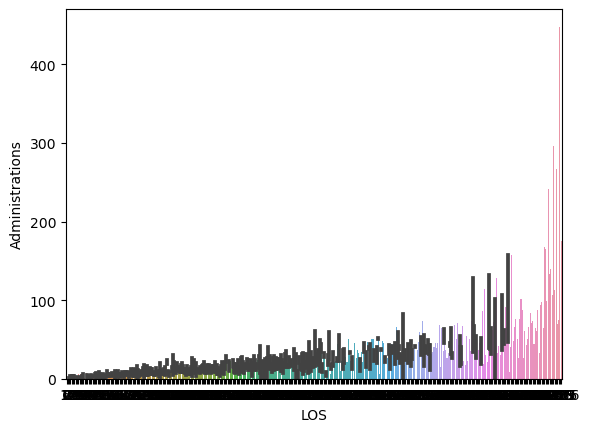

In [72]:
# Here we cannot see the number of people who fall into these ranges but rather only how total drug intake + days in clinic are  correlated
sns.barplot(data=df,x='LOS',y='Administrations')

<Axes: >

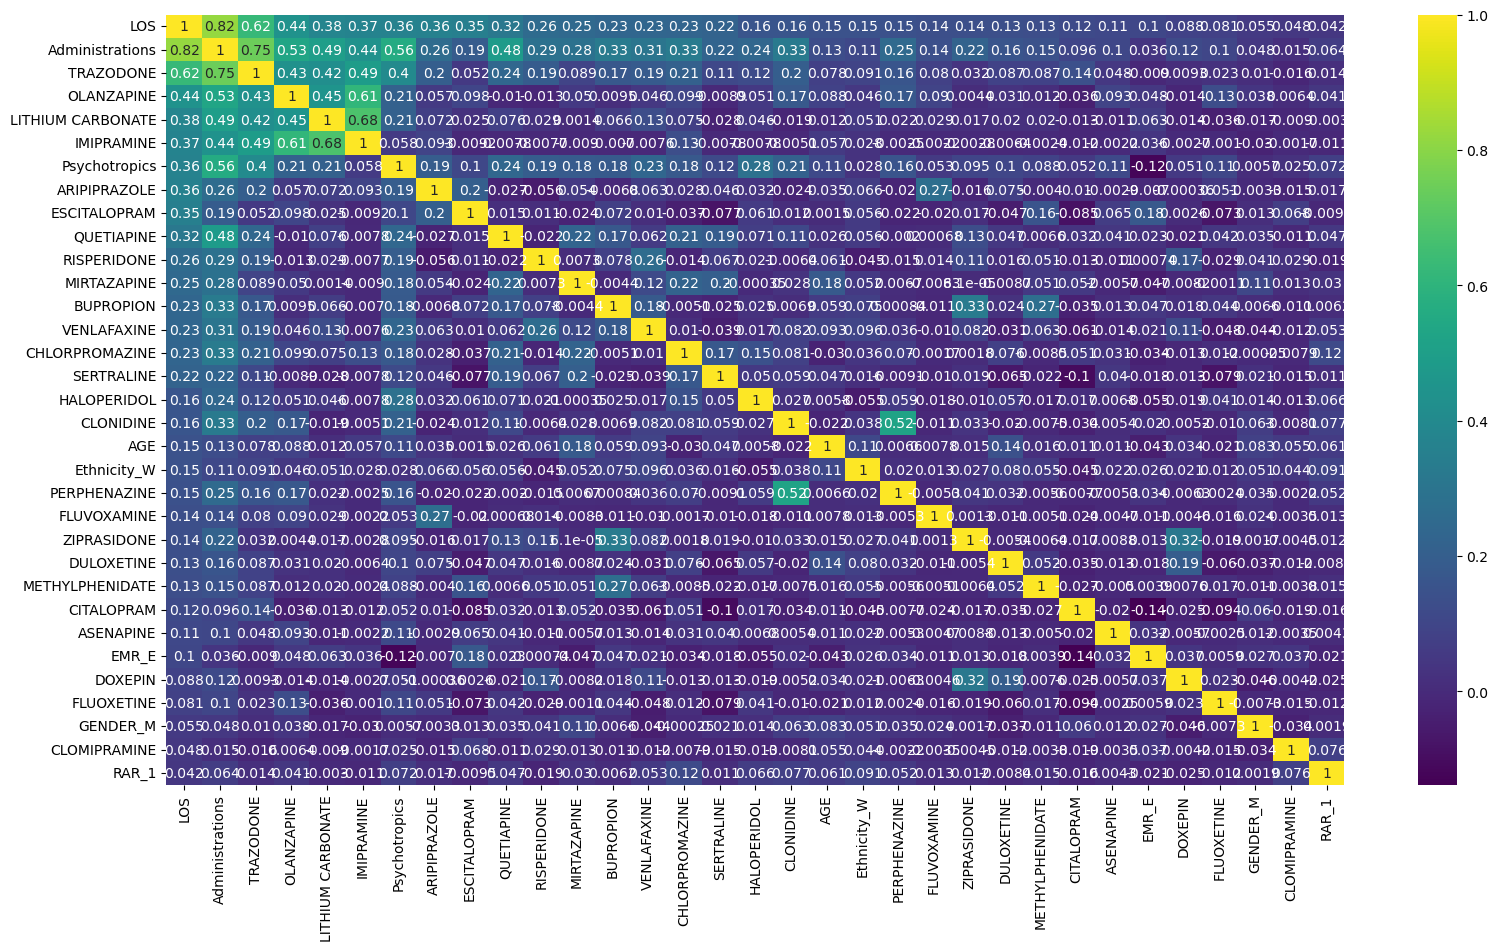

In [73]:
# There seems to be a correlation between the length of stay (LOS) and the amount of medications patients had to take
# Let's corroborate that presumption by plotting a heatmap!
df = pd.get_dummies(df,drop_first=True)
plt.figure(figsize=(19,10),dpi=100)
# Let's plot all but the 10 least significant features into a matrix and see how strong the correlations are
cols = df.corr().nlargest(df.shape[-1]-10, 'LOS')['LOS'].sort_values(ascending=False).index
sns.heatmap(df[cols].corr(),annot=True,cmap='viridis')

In [74]:
# Too many features, isn't it?
clean_useless_cols(df,'LOS')

#########################
starting with 43 cols
#########################
Ethnicity_L                -0.117303
Therapeutic Guidances_TL   -0.018936
Assignment_S               -0.015783
Ethnicity_O/U              -0.007750
Therapeutic Guidances_EG   -0.000599
GUANFACINE                  0.001720
PALIPERIDONE                0.024547
NORTRIPTYLINE               0.026715
FLUPHENAZINE                0.029633
AMITRIPTYLINE               0.037848
RAR_1                       0.041562
CLOMIPRAMINE                0.047644
GENDER_M                    0.055221
FLUOXETINE                  0.081288
DOXEPIN                     0.087580
EMR_E                       0.102187
ASENAPINE                   0.107538
CITALOPRAM                  0.118958
METHYLPHENIDATE             0.132398
DULOXETINE                  0.134456
ZIPRASIDONE                 0.136299
FLUVOXAMINE                 0.137049
PERPHENAZINE                0.145608
Ethnicity_W                 0.147241
AGE                         0.149108
C

In [75]:
n_leftover_patients = df[df['LOS']<=outliers_std[0]].to_numpy().shape[0]
n_starting_patients = df.shape[0]

percentage = (n_leftover_patients / n_starting_patients) * 100
print("Std-Drop: Percentage of patients retained: {:.2f}%".format(percentage))

n_leftover_patients = df[df['LOS']<=outliers_iqr[0]].to_numpy().shape[0]
n_starting_patients = df.shape[0]

percentage = (n_leftover_patients / n_starting_patients) * 100
print("IQR-Drop: Percentage of patients retained: {:.2f}%".format(percentage))

# Considering ... I have opted for dropping outliers above the value given by the x1.5 IQR calculation

# Drop the columns
df.drop(df[df['LOS'] > outliers_iqr[0]].index,inplace=True)
print(f"Now set has {df.shape[0]} patients")

Std-Drop: Percentage of patients retained: 98.42%
IQR-Drop: Percentage of patients retained: 90.61%
Now set has 1322 patients


# Reduction ft

In [76]:
# Given the analysis above, let's try to solve this problem the simplest way: 
simplest_df = df[['LOS','Administrations']]
simplest_df.head()

,LOS,Administrations
Patient,,
1,70,6
2,309,27
4,115,14
5,120,11
6,120,13


In [77]:
# Here we are taking the most simplistic model only for the purpose of selecting features. No hparam tuning, just a base to choose our fts!
clf = LinearRegression()

# Split the data (2ft)
X = simplest_df.drop('LOS', axis=1)
y = simplest_df['LOS'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=SEED, shuffle=True, test_size=0.3)

clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
mae = np.around(mean_absolute_error(y_test,yhat),2)

cscores = cross_validate(
    clf, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)


cv_mae = np.around(abs(cscores['test_score'].mean()),2)
print(f'LinearRegression scores {cv_mae} MAE with 5-fold CV and {mae} MAE without it (2 ft)')

LinearRegression scores 40.67 MAE with 5-fold CV and 38.86 MAE without it (2 ft)


<Axes: >

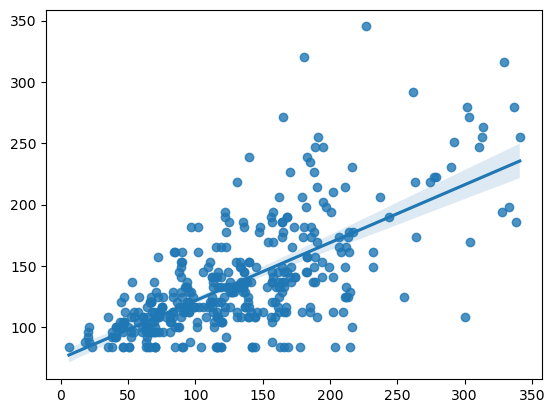

In [78]:
sns.regplot(x=y_test, y=yhat)

In [79]:
'''
Not satisfied with the results? 
Let's see what is the optimal number of features to take in!
Possible feature selection
'''

# Split the data (all ft)
X = df.drop('LOS', axis=1)
y = df['LOS'].to_numpy()

# TODO ColumnTransformer


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=SEED, shuffle=True, test_size=0.3)

# KBest
k = SelectKBest(chi2, k=5).fit(X_train, y_train)
KX_train = k.transform(X_train)
KX_test = k.transform(X_test)

clf.fit(KX_train,y_train)
y_pred = clf.predict(KX_test)
# Calculate MAE
mae = np.around(mean_absolute_error(y_test, y_pred),2)
# Calculate RMSE
rmse = np.around(np.sqrt(mean_squared_error(y_test, y_pred)),2)
print(f'SelectKBest scores: {mae} MAE, {rmse} RMSE')

pd.DataFrame({'ft': X.columns, 'score': k.scores_}
             ).sort_values('score', ascending=0).transpose()

SelectKBest scores: 51.26 MAE, 63.94 RMSE


,14,3,30,5,22,32,15,24,13,16,...,35,39,41,31,34,37,38,33,36,40
ft,FLUVOXAMINE,ASENAPINE,ZIPRASIDONE,CHLORPROMAZINE,OLANZAPINE,Administrations,GUANFACINE,PERPHENAZINE,FLUPHENAZINE,HALOPERIDOL,...,Ethnicity_O/U,RAR_1,Therapeutic Guidances_TL,Psychotropics,Ethnicity_L,Assignment_S,EMR_E,GENDER_M,Ethnicity_W,Therapeutic Guidances_EG
score,11634.875812,7021.210526,6592.164519,5953.656477,5772.013108,5380.833841,4907.781654,4702.611769,4578.514125,4559.016989,...,272.187525,271.760034,229.132814,213.582009,184.936654,175.891312,146.538416,137.572781,113.221365,70.991035


In [80]:
# Recurrent Feature Extraction 
rfe = RFE(clf,step=1).fit(X_train,y_train)
RX_train = rfe.transform(X_train)
RX_test = rfe.transform(X_test)

clf.fit(RX_train,y_train)
y_pred = clf.predict(RX_test)
# Calculate MAE
mae = np.around(mean_absolute_error(y_test, y_pred),2)
# Calculate RMSE
rmse = np.around(np.sqrt(mean_squared_error(y_test, y_pred)),2)
print(f'RFE says {X_train.columns[rfe.support_]} ({rfe.n_features_}) as best ft\'s to keep\n')
print(f'RFE scores: {mae} MAE, {rmse} RMSE')
pd.DataFrame({'ft':X.columns,'ranking':rfe.ranking_}).sort_values('ranking').transpose()

RFE says Index(['CLOMIPRAMINE', 'CLONIDINE', 'GUANFACINE', 'HALOPERIDOL', 'IMIPRAMINE',
       'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'NORTRIPTYLINE', 'PALIPERIDONE',
       'QUETIAPINE', 'RISPERIDONE', 'ZIPRASIDONE', 'Psychotropics',
       'Administrations', 'GENDER_M', 'Ethnicity_L', 'Ethnicity_O/U',
       'Ethnicity_W', 'EMR_E', 'RAR_1', 'Therapeutic Guidances_TL'],
      dtype='object') (21) as best ft's to keep

RFE scores: 35.48 MAE, 45.98 RMSE


,41,25,23,21,19,18,17,16,15,30,...,1,6,3,12,14,37,0,9,13,29
ft,Therapeutic Guidances_TL,QUETIAPINE,PALIPERIDONE,NORTRIPTYLINE,METHYLPHENIDATE,LITHIUM CARBONATE,IMIPRAMINE,HALOPERIDOL,GUANFACINE,ZIPRASIDONE,...,AMITRIPTYLINE,CITALOPRAM,ASENAPINE,FLUOXETINE,FLUVOXAMINE,Assignment_S,AGE,DOXEPIN,FLUPHENAZINE,VENLAFAXINE
ranking,1,1,1,1,1,1,1,1,1,1,...,13,14,15,16,17,18,19,20,21,22


RFECV scores: 34.54 MAE, 44.8 RMSE


Text(0.5, 0, 'ft')

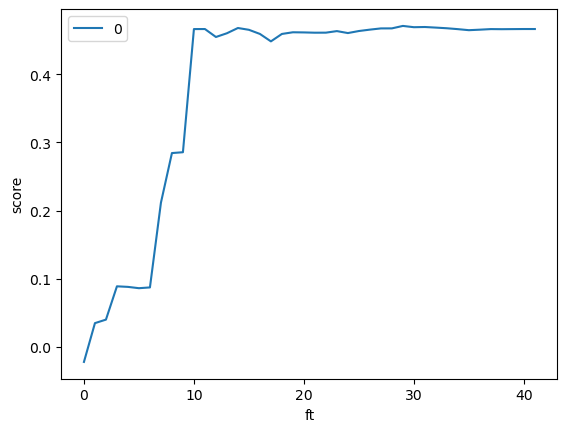

In [81]:
# Recurrent Feature Extraction with Cross-Validation
rfe = RFECV(clf,step=1).fit(X_train,y_train)
RX_train = rfe.transform(X_train)
RX_test = rfe.transform(X_test)

clf.fit(RX_train,y_train)
y_pred = clf.predict(RX_test)
# Calculate MAE
mae = np.around(mean_absolute_error(y_test, y_pred),2)
# Calculate RMSE
rmse = np.around(np.sqrt(mean_squared_error(y_test, y_pred)),2)
print(f'RFECV scores: {mae} MAE, {rmse} RMSE')
# Understanding where RFE CV hits the sweet spot number of features
dfplot = pd.DataFrame(rfe.cv_results_['mean_test_score']).plot()
# dfplot.set_xlim((0,16))
dfplot.set_ylabel('score')
dfplot.set_xlabel('ft')

In [82]:
# Lastly let's try PCA for dimensionality reduction
pca = PCA(n_components=2).fit(X_train)
PX_train = pca.transform(X_train)
PX_test = pca.transform(X_test)

clf.fit(PX_train,y_train)
y_pred = clf.predict(PX_test)
# Calculate MAE
mae = np.around(mean_absolute_error(y_test, y_pred),2)
# Calculate RMSE
rmse = np.around(np.sqrt(mean_squared_error(y_test, y_pred)),2)
print(f'PCA scores: {mae} MAE, {rmse} RMSE')

PCA scores: 38.35 MAE, 47.5 RMSE


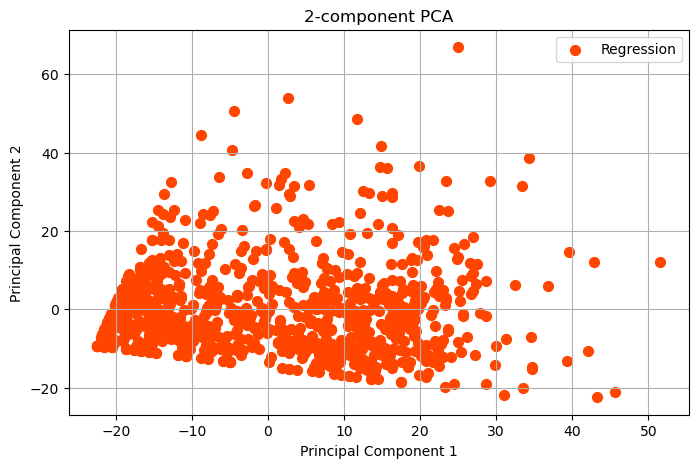

In [83]:
princ_df = pd.DataFrame(data=PX_train, columns=['pc1', 'pc2'])
pdf = pd.concat([princ_df, pd.Series(y_train, name='target')], axis=1)

fig = plt.figure(figsize=(8, 5))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2-component PCA')

targets = ['Regression']  # Assuming only one target for regression
colors = ['orangered']

for target, color in zip(targets, colors):
    indicesToKeep = pdf['target'].notnull()
    plt.scatter(pdf.loc[indicesToKeep, 'pc1'], pdf.loc[indicesToKeep, 'pc2'], c=color, s=50)

plt.legend(targets)
plt.grid()
plt.show()


In [84]:
'''ERRORS encountered on the way:

- The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Solution: Combine values so you don't end up with single y datapoint labels for very similar ranges OR don't use stratify during split!


- Getting low accuracy on a regression problem: Solution : Use MAE RMSE

- SimpleImputer for NaN causes loss of types when reconstructing to DataFrame

- Can't use StandardScaler before SelectKBest because input must be non negative

- ridge_regression CANNOT into pipeline, returns ndarray instead of estimator... use 'Ridge' instead

- GPU support on Keras (tensorflow) AND on Xgboost was a very painful thing to achieve... Partial credit goes to Mr. Jeff Heaton

- cudaErrorIllegalAddress: an illegal memory access was encountered when using XGBRFRegressor

'''

"ERRORS encountered on the way:\n\n- The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.\nSolution: Combine values so you don't end up with single y datapoint labels for very similar ranges OR don't use stratify during split!\n\n\n- Getting low accuracy on a regression problem: Solution : Use MAE RMSE\n\n- SimpleImputer for NaN causes loss of types when reconstructing to DataFrame\n\n- Can't use StandardScaler before SelectKBest because input must be non negative\n\n- ridge_regression CANNOT into pipeline, returns ndarray instead of estimator... use 'Ridge' instead\n\n- GPU support on Keras (tensorflow) AND on Xgboost was a very painful thing to achieve... Partial credit goes to Mr. Jeff Heaton\n\n- cudaErrorIllegalAddress: an illegal memory access was encountered when using XGBRFRegressor\n\n"

# Models

In [85]:
# Instantiate the models and the random search
X = StandardScaler().fit_transform(X)
y = df['LOS'].to_numpy()

# Perform split again after Kbest compat 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=SEED, shuffle=True, test_size=0.3)

# Following guidelines from: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
clf1 = Ridge(random_state=SEED)
clf2 = SVR()
clf3 = XGBRegressor(tree_method='gpu_hist',gpu_id=-1)
clf4 = ElasticNet(random_state=SEED)
clf5 = Lasso(random_state=SEED)
# clf6 = MLPRegressor(random_state=SEED)

# Define the hyperparameter search space
param_grid1 = {
    'clf': [clf1],
    'clf__alpha': [0.1, 1.0, 10.0],
    'clf__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'clf__tol': [0.0001, 0.001, 0.01]
}
param_grid2 = {
    'clf': [clf2],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto'],
    'clf__epsilon': [0.01, 0.1, 1.0]
}
param_grid3 = {
    'clf': [clf3],
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__gamma': [0.0, 0.1, 0.2],
    'clf__reg_alpha': [0.0, 0.1, 0.2],
    'clf__reg_lambda': [0.0, 0.1, 0.2]
}
param_grid4 = {
    'clf': [clf4],
    'clf__alpha': [0.1, 1.0, 10.0],
    'clf__l1_ratio': [0.25, 0.5, 0.75],
    'clf__tol': [1e-2, 1e-3, 1e-4, 1e-5]
}
param_grid5 = {
    'clf': [clf5],
    'clf__alpha': [0.1, 1.0, 10.0],
    'clf__tol': [0.0001, 0.001, 0.01]
}
# param_grid6 = {
#     'clf': [clf6],
#     'clf__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
#     'clf__activation': ['relu', 'tanh'],
#     'clf__solver': ['adam', 'sgd'],
#     'clf__learning_rate': ['constant', 'adaptive'],
#     'clf__learning_rate_init': [0.001, 0.01, 0.1],
#     'clf__alpha': [0.0001, 0.001, 0.01],
#     'clf__max_iter': [100, 200, 500],
#     'clf__early_stopping': [True, False]
# }
pipe = Pipeline([('clf', clf1)])
param_grid = [param_grid1, param_grid2, param_grid3, param_grid4, param_grid5]

# Begin search
random_search = RandomizedSearchCV(
    pipe, param_grid, cv=2, n_jobs=-1, random_state=SEED, scoring='neg_mean_absolute_error', verbose=4,return_train_score=True)

# RAW untouched data
# df = pd.read_csv('Dataset.csv',encoding='utf-8')
# X = pd.get_dummies(df.drop('LOS',axis=1),drop_first=True)

random_search.fit(X, y)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END clf=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=-1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...), clf__colsample_bytree=0.8, clf__gamma=0.1, clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=100, clf__reg_alpha=0.2, clf__reg_lambda=0.1, clf__subsample=0.8;, score=(trai

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('clf', Ridge(random_state=101))]),
                   n_jobs=-1,
                   param_distributions=[{'clf': [Ridge(random_state=101)],
                                         'clf__alpha': [0.1, 1.0, 10.0],
                                         'clf__solver': ['auto', 'svd',
                                                         'cholesky', 'lsqr',
                                                         'sparse_cg', 'sag',
                                                         'saga'],
                                         'clf__tol': [0.0001, 0.001, 0.01]},
                                        {'clf': [SVR()],
                                         'clf__C': [0.1, 1.0, 10.0],
                                         'clf__epsilon': [0.01, 0.1, 1.0],
                                         '...
                                         'clf__reg_lambda': [0.0, 0.1, 0.2],
                                         'clf__subsample': [0.8, 1.0]},
                                        {'clf': [ElasticNet(random_state=101)],
                                         'clf__alpha': [0.1, 1.0, 10.0],
                                         'clf__l1_ratio': [0.25, 0.5, 0.75],
                                         'clf__tol': [0.01, 0.001, 0.0001,
                                                      1e-05]},
                                        {'clf': [Lasso(random_state=101)],
                                         'clf__alpha': [0.1, 1.0, 10.0],
                                         'clf__tol': [0.0001, 0.001, 0.01]}],
                   random_state=101, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=4)

In [86]:
# TODO  Skipping model due to randomness
pd.DataFrame(random_search.cv_results_)['param_clf']
# Call rands 6 times so all models can be trained (and not skipped!)
# Isolate the problem by not specifying all the params in the param list, 
# param_grid = [param_grid1, param_grid2, param_grid3, param_grid4, param_grid5,param_grid6] -> {clf,clf__}
# Rerun your code with a SINGLE param list

0    XGBRegressor(base_score=None, booster=None, ca...
1    XGBRegressor(base_score=None, booster=None, ca...
2    XGBRegressor(base_score=None, booster=None, ca...
3    XGBRegressor(base_score=None, booster=None, ca...
4    XGBRegressor(base_score=None, booster=None, ca...
5    XGBRegressor(base_score=None, booster=None, ca...
6                                                SVR()
7    XGBRegressor(base_score=None, booster=None, ca...
8    XGBRegressor(base_score=None, booster=None, ca...
9    XGBRegressor(base_score=None, booster=None, ca...
Name: param_clf, dtype: object

In [87]:
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", np.around(abs(random_search.best_score_),2),'MAE')

Best Hyperparameters:  {'clf__subsample': 0.8, 'clf__reg_lambda': 0.1, 'clf__reg_alpha': 0.1, 'clf__n_estimators': 100, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__gamma': 0.1, 'clf__colsample_bytree': 0.8, 'clf': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=-1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)}
Best Score:  31.47 MAE


In [88]:
random_search.best_estimator_[0].feature_importances_ # XGB Gives 32st ft as most important
df.columns[32]

'Psychotropics'

/home/maestro/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


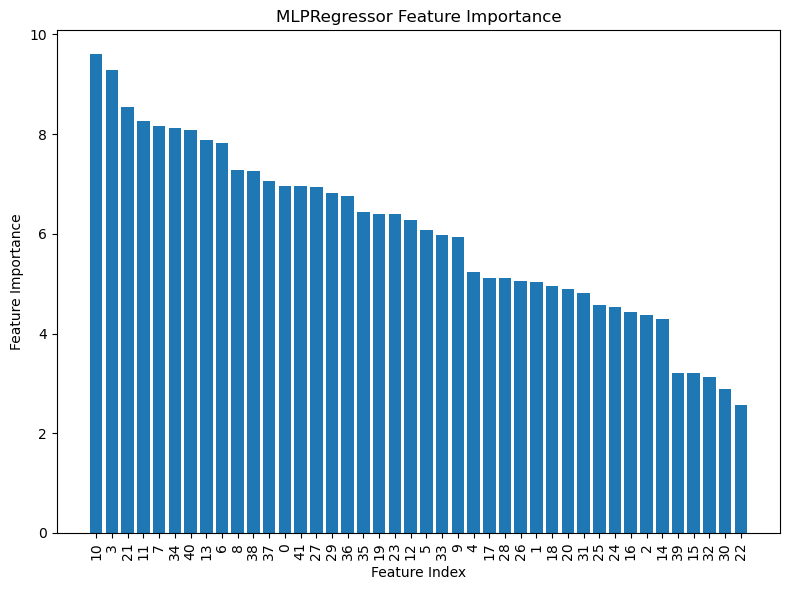

In [89]:
# Train your MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(10, 10))  # Example architecture
model.fit(X_train, y_train)

# Get the weights of the input layer
input_layer_weights = model.coefs_[0]

# Calculate the feature importance based on the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(input_layer_weights), axis=1)

# Sort the feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance)
plt.xticks(range(len(sorted_feature_importance)), sorted_indices, rotation='vertical')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('MLPRegressor Feature Importance')
plt.tight_layout()
plt.show()

In [90]:
df.columns[7]

'CITALOPRAM'

# Keras

In [91]:
'''Attention! 
The following code (only this snippet) has been taken from the Keras Documentation
See: https://keras.io/guides/keras_tuner/getting_started/ for retreiving its original source (and authors). NOT of my authority!''' 
from functools import partial
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization


def build_model(hp):
    model = Sequential()
    model.add(Flatten())
    for layer in range(hp.Int("n_hidden", min_value=1, max_value=2, step=1)):
        RegularizedDense = partial(Dense, units=hp.Int("units", min_value=20, max_value=5000, step=1),activation=hp.Choice("activation", ["relu", "tanh"]),
        kernel_regularizer=l1_l2(0.01))
        model.add(RegularizedDense())
            # TODO add MAXPOOLING, DROPOUT, BATCHNORM, CONV2d, LeakyReLU layers and try ! :) 
        model.add(BatchNormalization()),
        
            # Tune whether to use dropout.
        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.25))
    # Output layer
    model.add(Dense(1))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=9e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mean_absolute_error",
    )
    return model

# Define the objective for regression
# objective = Objective("val_mae", direction="min")

# def build_model(n_hidden,acti,l_rate,i_shape):
#     model = Sequential()
#     model.add(Flatten())
#     model.add(
#         Dense(
#             # Tune number of units.
#             units=n_hidden,
#             # Tune the activation function to use.
#             activation=acti,
#             input_shape=i_shape
#         )
#     )
#     model.add(Dense(1))
#     # Define the optimizer learning rate as a hyperparameter.
#     learning_rate = l_rate
#     model.compile(
#         optimizer=Adam(learning_rate=learning_rate),
#         loss="mean_absolute_error",
#         metrics=[MeanAbsoluteError()],
#     )
#     return model

history = build_model(HyperParameters()).fit(X_train,y_train,validation_data=(X_test,y_test),verbose=4)
history.history

2023-05-18 14:26:14.744486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-18 14:26:14.745099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-18 14:26:14.745488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-18 14:26:15.484781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-18 14:26:15.484899: I tensorflow/compile

{'loss': [140.87998962402344], 'val_loss': [131.9532012939453]}

In [92]:
from keras.callbacks import EarlyStopping,BackupAndRestore

tuner = RandomSearch(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=2,
    executions_per_trial=3,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
backup_and_restore = BackupAndRestore('my_checkpoint_dir')


tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test),callbacks=[early_stopping,backup_and_restore])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, X.shape[-1]))
best_model.summary()
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train, y_test))
model.fit(x=X, y=y, epochs=1)

Trial 2 Complete [00h 01m 47s]
val_loss: 80.45087432861328

Best val_loss So Far: 33.208882649739586
Total elapsed time: 00h 02m 15s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 27)                1161      
                                                                 
 batch_normalization (BatchN  (None, 27)               108       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 27)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 28        
                 